In [1]:
# Install the required packages

# !pip install torch torchvision torchaudio tensorflow tensorflow-datasets --extra-index-url https://download.pytorch.org/whl/cu113

## Step 1: Load the IMDb Dataset

In [2]:
import tensorflow_datasets as tfds
import numpy as np

imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

2024-04-09 18:31:42.443257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 2: Preprocess the Data

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

tokenizer.fit_on_texts([text.numpy().decode('utf8') for text, label in train_data])


def convert_to_padded_sequences(dataset):
    sequences = tokenizer.texts_to_sequences([text.numpy().decode('utf8') for text, label in dataset])
    padded_sequences = pad_sequences(sequences, maxlen=120, truncating='post', padding='post')
    labels = np.array([label.numpy() for text, label in dataset])
    return padded_sequences, labels

train_sequences, train_labels = convert_to_padded_sequences(train_data)
test_sequences, test_labels = convert_to_padded_sequences(test_data)

2024-04-09 18:31:51.239768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-09 18:31:57.835226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-09 18:32:03.495022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-09 18:32:07.752403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-09 18:32:13.489403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 3: Create PyTorch Data Loaders

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader


train_data = TensorDataset(torch.from_numpy(train_sequences).long(), torch.from_numpy(train_labels).long())
test_data = TensorDataset(torch.from_numpy(test_sequences).long(), torch.from_numpy(test_labels).long())


batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Step 4: Define the RNN Model
First, we'll define the RNN model class. PyTorch makes this straightforward with its nn.Module class.

In [5]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(x.size(0), -1)
        sig_out = sig_out[:, -1]  
        return sig_out  
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden


## Step 5: Instantiate the Model
Now, we'll instantiate the RNN model with the necessary parameters.

In [6]:
vocab_size = 10000 + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256 
n_layers = 2
model = SentimentRNN(vocab_size=vocab_size, output_size=output_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_layers=n_layers)

## Step 6: Training Setup
Before training the model, we define the loss function and the optimizer.

In [7]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Step 7: Training the Model
This step involves iterating over our training data, performing the forward pass, calculating the loss, and then updating our model parameters (weights).

In [8]:
epochs = 4
clip = 5

for epoch in range(epochs):
    for inputs, labels in train_loader:
        current_batch_size = inputs.size(0)
        h = model.init_hidden(current_batch_size)
        
        h = tuple([each.data for each in h])  # Detach hidden state from its history
        inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
        
        model.zero_grad()
        
        output = model(inputs, h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    print(f'Epoch: {epoch+1}/{epochs}... Loss: {loss.item()}')


Epoch: 1/4... Loss: 0.6760882139205933
Epoch: 2/4... Loss: 0.4003819227218628
Epoch: 3/4... Loss: 0.3395270109176636
Epoch: 4/4... Loss: 0.3052422106266022


## Step 8: Evaluating the Model
After training, we'll want to evaluate the performance of our model on the test set. This step involves running our model in inference mode (model.eval()) to make predictions, and then comparing these predictions against the actual labels to compute accuracy or other relevant metrics.

In [9]:
model.eval()

test_losses = []
num_correct = 0
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        current_batch_size = inputs.size(0)
        h = model.init_hidden(current_batch_size)

        inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)

        output = model(inputs, h)  
        
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        pred = torch.round(output.squeeze())  
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy()) 
        num_correct += np.sum(correct)
        
        probs = torch.sigmoid(output).cpu().numpy()  
        batch_predictions = [1 if prob > 0.5 else 0 for prob in probs]
        predictions.extend(batch_predictions)
        actuals.extend(labels.cpu().numpy()) 

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct / len(test_loader.dataset)
print(f"Test accuracy: {test_acc*100:.3f}%")


Test loss: 0.410
Test accuracy: 81.788%


## Step 9: Model Performance Metrics
Begin by summarizing the performance of our model using metrics such as accuracy, precision, recall, and F1-score. These metrics will give us a broad view of how well our model is performing.

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(actuals, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667


## Step 10: Error Analysis
Next,we perform an error analysis by examining instances where our model made incorrect predictions. This can help identify patterns in the data that our model is struggling with.

In [12]:
test_texts = []
test_labels = []

for text, label in test_data:
    test_texts.append(text.numpy())
    test_labels.append(label.numpy())



In [13]:
incorrects = np.where(np.array(predictions) != np.array(actuals))[0]
print("Indices of incorrect predictions:", incorrects)

for index in incorrects[:5]:  # Just look at the first 5 for brevity
    print(f"Review: {test_texts[index]}")
    print(f"Predicted: {'Positive' if predictions[index] else 'Negative'}, Actual: {'Positive' if test_labels[index] else 'Negative'}\n")


Indices of incorrect predictions: [    2     3     8 ... 24991 24995 24997]
Review: [ 627   18  298  468 1709   18 1305   18  909    2    1   22  158 1626
   18    3  158  993   18  229 3767   18    2    1    9    4  199   13
  684    1 2256    2 2108  510  148  635  972   10   11   26    4 1792
 1462   16 2233  139   15 4612    3    2 1296 1055   19   23  122  872
    1    4 3143   36   76   52   23   68   65    2 1986    4 3676  123
    9  190    2   62  153   13  236   64    1   23   81  168    6   65
   12 1688    7    2  964  161   19 2566 2220   44 2812    1    8    8
   23   68  374   27  736    2  276    1   13   40   27    1    6  138
  178   17    2 1693   38    4   50    1]
Predicted: Positive, Actual: Negative

Review: [ 337 4407    1  495  252    6 6266   47    1    6   12    1 3288 4967
  233   50   18   19  439    1   32    2  519  243 6555    5    4   20
  196   22    2  220  225 9451    9  633    8    8   12   14  524   32
 3381    1  120   27   26    4    1  235   73 

## Step 11: Model Interpretation
Consider using libraries like captum for PyTorch to interpret our model's predictions. This can provide insights into which parts of the input data our model is focusing on when making predictions.

In [14]:
def model_wrapper(input_tensor):
    batch_size = input_tensor.size(0)  # Assuming input_tensor is batched
    hidden = model.init_hidden(batch_size)
    
    hidden = tuple(h.to(input_tensor.device) for h in hidden)
    
    output, _ = model(input_tensor)
    return output

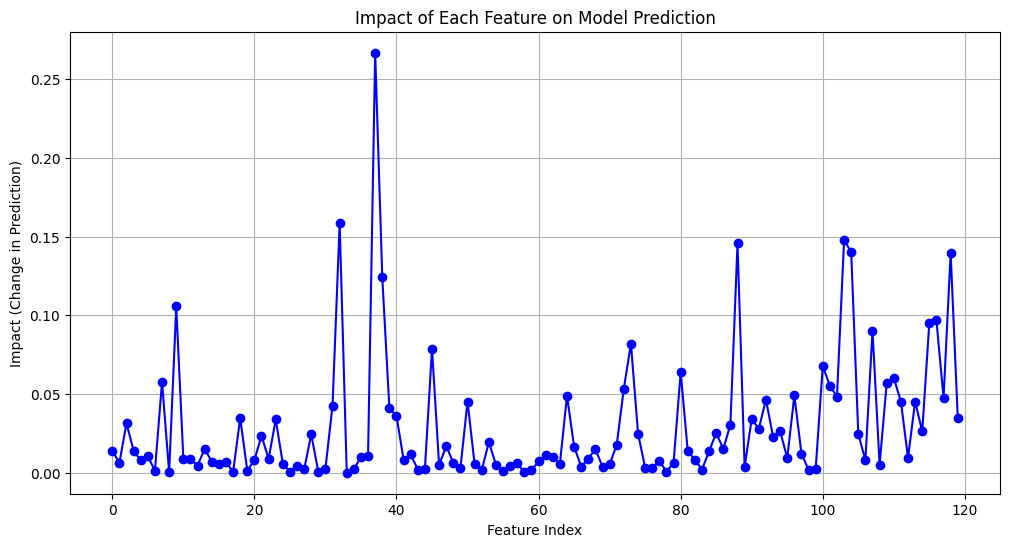

In [15]:
import torch
import matplotlib.pyplot as plt

def manual_feature_ablation(model, input_tensor, baseline_value=0):
    model.eval()
    
    original_pred = model(input_tensor)
    
    feature_impacts = []
    for i in range(input_tensor.size(1)):  
        ablated_input = input_tensor.clone()
        ablated_input[:, i] = baseline_value  
        
        ablated_pred = model(ablated_input)
        
        change_in_pred = (original_pred - ablated_pred).abs()
        
        feature_impacts.append(change_in_pred.item())
    
    return feature_impacts

input_tensor = torch.tensor(test_sequences[0:1]).long()
input_tensor = input_tensor.to(next(model.parameters()).device)

feature_impacts = manual_feature_ablation(model, input_tensor)

plt.figure(figsize=(12, 6))
plt.plot(feature_impacts, marker='o', linestyle='-', color='b')
plt.title('Impact of Each Feature on Model Prediction')
plt.xlabel('Feature Index')
plt.ylabel('Impact (Change in Prediction)')
plt.grid(True)
plt.show()
